# Projeto SuperComputação 2023.2

## Análise de Redes Sociais: encontrando a clique máxima em um grafo.

![Exemplo Clique](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png)


A análise de redes sociais (ARS) é uma abordagem oriunda de áreas tais como Sociologia, Psicologia Social e Antropologia. Tal abordagem estuda as ligações relacionais (*relational tie*) entre atores sociais. Os atores na ARS podem ser tanto pessoas e empresas, analisadas como unidades individuais, quanto unidades sociais coletivas como, por exemplo, departamentos dentro de uma organização, agências de serviço público em uma cidade, estados-nações de um continente, dentre outras. A ARS difere fundamentalmente de outros estudos pelo fato de que sua ênfase não é nos atributos (características) dos atores, mas nas ligações entre eles.


A idéia de uma clique em um grafo é relativamente simples. No nível mais geral, uma clique é um subconjunto de uma rede no qual os atores são mais próximos entre si do que com outros membros da rede. Em termo de laços de amizade, por exemplo, não é incomum encontrar grupos humanos que formam cliques baseando-se em idade, gênero, raça, etnia, religião, ideologia, e muitas coisas coisas. Uma clique é, portanto, um conjunto de vértices em um grafo em que cada par de vértices está diretamente conectado por uma aresta.

Encontrar a clique máxima em um grafo é uma tarefa computacionalmente desafiadora devido à natureza combinatória do problema.  A dificuldade computacional surge da necessidade de explorar todas as combinações possíveis de vértices para identificar a maior clique, o que se torna exponencial em relação ao número de vértices. Isso resulta em uma complexidade computacional alta, mesmo para grafos moderadamente grandes.

A importância de estudar cliques está notavelmente presente na análise de redes sociais, onde as cliques representam grupos coesos de indivíduos que compartilham interesses, amizades ou conexões em comum. A identificação de cliques ajuda a entender a estrutura de uma rede social, identificar influenciadores e grupos de afinidade, além de auxiliar na detecção de comunidades e na análise de dinâmicas sociais.

As cliques são importantes, pois além de desenvolver em seus membros comportamentos homogêneos, elas têm, por definição, grande proximidade, aumentando a velocidade das trocas. Assim, informações dirigidas a uma clique são rapidamente absorvidas pelos seus membros, que tendem a percebê-las de forma semelhante. Isso é importante, por exemplo, em estratégias de segmentação.


Portanto, a resolução eficiente do problema da clique máxima tem aplicações valiosas em áreas que vão desde a ciência da computação até a análise de dados em redes sociais.

## SUA TAREFA: Encontrar a clique máxima em um grafo.

Seu programa deve receber um grafo a partir de um input de texto (abaixo você vai encontrar o código gerador do input). A partir da leitura do arquivo, você deve armazenar o grafo computacionalmente (matriz de adjacência, por exemplo). E com isso, você deverá executar três implementações:

1. **Abordagem Exaustiva**

A exaustão é uma abordagem que seleciona iterativamente os vértices para formar um clique, geralmente começando com um vértice e adicionando outros que tenham o maior número de vizinhos já na clique. Aqui está um pseudo-código simplificado para detectar cliques em um grafo usando essa abordagem. ATENÇÃO: esse pseudo-codigo **não** é a solução completa dessa abordagem. Você pode se inspirar nele para compreender como resolver o problema, mas é parte de sua tarefa desenvolver a solução.

```
Função EncontrarCliqueMaxima(grafo, numVertices)
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()  # Inicialmente, todos os nós são candidatos

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar for Verdadeiro Então
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos for Verdadeiro Então
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            candidatos = novosCandidatos
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função


```

Implemente o código em C++.

Aproveite para pensar se é possível adotar alguma heurística. Por exemplo, ordenar os nós em função do grau de adjacência, ajuda?


**Sua segunda tarefa**: Até qual tamanho de problema você conseguiu obter um resultado em tempo hábil (aprox. 15 min)? Você deve apresentar um pseudo-codigo de uma heurística para otimizar essa tarefa exaustiva. É possível implementar alguma poda? Algum critério que evite calcular um nó, dado que você já descobriu uma clique maior?



Grafo densamente conectado gerado e salvo em 'grafo.txt'.


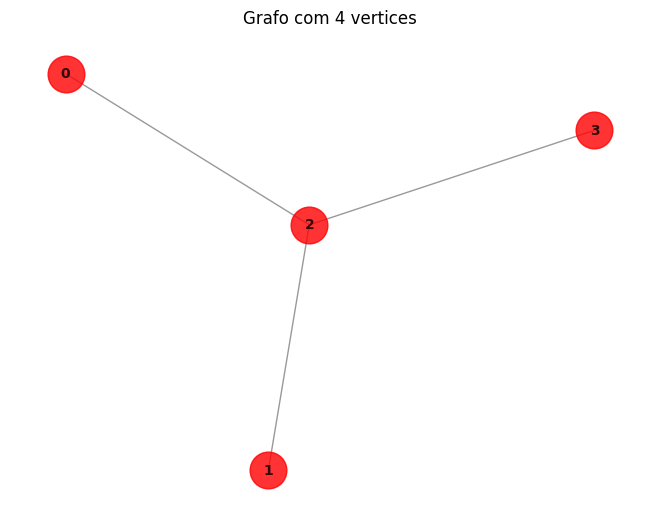

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def desenha_grafo(nome_arquivo, num_vertices, show):
  # Parâmetros
  probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

  # Crie um grafo aleatório densamente conectado
  grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

  # Abra o arquivo para escrita
  with open(nome_arquivo, 'w') as arquivo:
      # Escreva a quantidade de vértices e número de arestas na primeira linha
      arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

      # Escreva as arestas no formato de lista de adjacência
      for aresta in grafo.edges():
          arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

  print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")

  # Desenha Grafo
  pos = nx.spring_layout(grafo)
  nx.draw(grafo, pos, with_labels=True, font_weight='bold', node_size=700, node_color='red',
          font_color='black', font_size=10, edge_color='gray', linewidths=1, alpha=0.8)

  plt.title("Grafo com " + str(num_vertices) + " vertices")
  plt.savefig(nome_arquivo + "-" + str(num_vertices) +  '.png')

  if(show):
    plt.show()

num_vertices = 4
desenha_grafo("grafo.txt", num_vertices, False)

```
Busca Exaustiva Local
```

Nesse algorítimo inicial para a busca do clique máximo de um grafo, começamos com uma solução inicial e , em seguida, iteramos localmente para melhorar a solução, no caso desse algoritimo, adicionamos vertices adjacentes a solução inicial ao clique máxima.

O algoritmo pode ficar preso em ótimos locais e não explorar soluções mais amplas.

In [9]:
%%writefile busca_exaustiva_local.cpp

#include<iostream>
#include<vector>
#include <fstream>
#include<algorithm>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string& nomeArquivo, int& numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}


// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

vector<int> EncontrarCliqueMaximoLocal(vector<vector<int>> grafo, int numVertices) {
    /*
    * Calcula clique máximo local do grafo
    */

    vector<int> cliqueMaximo;
    vector<int> candidatos;

    // No inicio todos os nós são candidatos
    for (int i = 0; i < numVertices; ++i) {
        candidatos.push_back(i);
    }

    // Enquanto lista de candidados não vazia
    while(!candidatos.empty()){
        int v = candidatos.back();
        candidatos.pop_back();


        bool podeAdicionar = true;
        for (int u : cliqueMaximo) {
            if (grafo[u][v] == 0) {
                podeAdicionar = false;
                break;
            }
        }

        if (podeAdicionar) {
            cliqueMaximo.push_back(v);
            vector<int> novosCandidatos;

            for (int u : candidatos) {
                bool adjacenteATodos = true;

                for (int c : cliqueMaximo) {
                    if (grafo[u][c] == 0) {
                        adjacenteATodos = false;
                        break;
                    }
                }

                if (adjacenteATodos) {
                    novosCandidatos.push_back(u);
                }
            }

            candidatos = novosCandidatos;
        }
   }

   return cliqueMaximo;
}


// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaximo){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaximo) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaximo.size();
}

vector<int> main() {

    string nomeArquivo = "grafo.txt";
    int numVertices = 4;

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);
    vector<int> cliqueMaximo =  EncontrarCliqueMaximoLocal(grafo,numVertices);

    display_result("Busca Exaustiva Local", cliqueMaximo);

    return cliqueMaximo ;
}



Overwriting busca_exaustiva_local.cpp


In [10]:
!g++ -O3 -Wall busca_exaustiva_local.cpp -o busca_exaustiva_local

In [11]:
!./busca_exaustiva_local

 ===== [Busca Exaustiva Local] ===== 

 > Clique Máxima encontrada : [4 3 ] 

 > Tamanho : 2

In [12]:
import networkx as nx

def cliqueMaximo_Resposta(nome_arquivo):
  # Abrir o arquivo e pular a primeira linha
  with open(nome_arquivo, 'r') as arquivo:
      next(arquivo)  # Pula a primeira linha

      # Lê o grafo a partir das linhas restantes
      G = nx.parse_adjlist(arquivo)

  # Encontrar todas as cliques maximais
  cliques_maximais = list(nx.find_cliques(G))

  # Encontrar a clique máxima (a maior)
  clique_maxima = max(cliques_maximais, key=len)

  print(" ===== [ RESPOSTAS ] ===== ")
  print("\n > Cliques maximais encontradas:")
  for clique in cliques_maximais:
      print(clique)

  print("\n > Clique máxima encontrada:", clique_maxima)
  print("\n > Clique máxima tamanho:", len(clique_maxima))

cliqueMaximo_Resposta("grafo.txt")

 ===== [ RESPOSTAS ] ===== 

 > Cliques maximais encontradas:
['3', '1']
['3', '2']
['3', '4']

 > Clique máxima encontrada: ['3', '1']

 > Clique máxima tamanho: 2




```
Busca Exaustiva Global
```

Para a implementação da busca exaustiva global, é preciso utilizar um algorítimo de busca exaustiva que explore todas as possíveis combinações de nós para encontrar a maior clique de um grafo.

In [28]:
%%writefile busca_exaustiva_global.cpp

#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string& nomeArquivo, int& numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char* argv[]) {

    if(argc != 2 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 2 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices;

    // ------ Lê Grafo ------
    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    display_result("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}


Overwriting busca_exaustiva_global.cpp


In [29]:
!g++ -O3 -Wall busca_exaustiva_global.cpp -o busca_exaustiva_global

In [30]:
!./busca_exaustiva_global grafo.txt

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : [4 3 ] 

 > Tamanho : 2

In [16]:
import networkx as nx

def cliqueMaximo_Resposta(nome_arquivo):
  # Abrir o arquivo e pular a primeira linha
  with open(nome_arquivo, 'r') as arquivo:
      next(arquivo)  # Pula a primeira linha

      # Lê o grafo a partir das linhas restantes
      G = nx.parse_adjlist(arquivo)

  # Encontrar todas as cliques maximais
  cliques_maximais = list(nx.find_cliques(G))

  # Encontrar a clique máxima (a maior)
  clique_maxima = max(cliques_maximais, key=len)

  print(" ===== [ RESPOSTAS ] ===== ")
  print("\n > Cliques maximais encontradas:")
  for clique in cliques_maximais:
      print(clique)

  print("\n > Clique máxima encontrada:", clique_maxima)
  print("\n > Clique máxima tamanho:", len(clique_maxima))

cliqueMaximo_Resposta("grafo.txt")

 ===== [ RESPOSTAS ] ===== 

 > Cliques maximais encontradas:
['3', '1']
['3', '2']
['3', '4']

 > Clique máxima encontrada: ['3', '1']

 > Clique máxima tamanho: 2


```
Busca Exaustiva com Heuristica - Grau dos Vértices
```

Podemos definir o grau de adjacencia de um grafo simples como:

> O grau de um vértice , com o grafo representado em uma matriz de adjacencia, é dado pela soma dos elementos de sua linha (ou coluna) correspondente. [1]

ou, similarmente, também pode ser definido como:

> O grau de um vértice v em um grafo G também pode
ser visto como a quantidade de arestas incidentes em
v. [2]

Para facilitar o entendimento desse conceito, observe o grafo abaixo apresentado:

<img alt="Exemplo de calculo de grau do nó" src="calcula_grau_exemplo.png" />

Temos que o grau dos vertices é dado pela quantidade de arestas ligadas a ele (no caso de um grafo não direcional, não faz diferença se essas arestas são de entrada ou de saída):

$$d(v1) = 2$$

$$d(v2) = 1$$

$$d(v3) = 3$$

$$d(v4) = 2$$

$$d(v5) = 0$$


É possível inferir que a estratégia de ordenar os vertices de acordo com o seu grau de adjacencia seja uma estratégia eficaz para melhorar o desempenho do algorítimo. Isso se deve ao fato de que os vértices com maiores graus de adjacência tendem a ter uma maior probabilidade de pertencer a clique máxima, visto que em um clique, todos os vértices estão concetados entre si.


[1] https://www.ibilce.unesp.br/Home/Departamentos/MatematicaAplicada/socorro4029/representa_grafos2.pdf

[2] https://www.facom.ufms.br/~fhvm/disciplinas/anteriores/2005/grafos/aula2.pdf

Utilizando como base o pseudocódigo inicialmente fornecido (`Busca Exaustiva Local`), podemos pensar nas seguintes implemnetações para a ordenação pelo calculo de adjacência:



```cpp

Função calculaGrau(grafo, vertice):
    grau = 0
    
    para cada vizinho em grafo[nó]:
        se existe_aresta(vertice, vizinho):
            grau +=1
    retornar grau

Função OrdenarPorGrau(grafo, vertice1, vertice2):
    retorna calculaGrau(grafo, vertice2) - calculaGrau(grafo, vertice1)

Função EncontrarCliqueMaximaOrdenada(grafo, numVertices):
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    // Ordena lista de candidatos usando a função OrdenaPorGrau
    sort(candidatos, OrdenarPorGrau);

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            // Ordena novos candidatos por grau
            sort(novosCandidatos, OrdenarPorGrau);

            candidatos = novosCandidatos
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função

```





2. **Implementação com Threads OpenMP**

A implementação de uma solução com OpenMP para encontrar cliques em um grafo usando a heurística gulosa envolve a paralelização das iterações do algoritmo em diferentes threads. O OpenMP simplifica a criação de threads e a coordenação entre elas.


Nessa implementação você deve apresentar o código-fonte modificado, justificar a alteração feita, e mostrar também o speed up obtido. Faça uso de gráficos e tabelas para mostrar que sua implementação em openMP valeu a pena. Observe que mesmo assim você não vai conseguir resolver exaustivamente o problema, mas o tamanho do grafo será maior, e o tempo de processamento para um mesmo tamanho deve ser preferencialmente menor.


In [48]:
%%writefile busca_exaustiva_global_omp.cpp

#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <omp.h>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string& nomeArquivo, int& numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    #pragma omp parallel for
    for (int i = 0; i < numArestas; ++i) {
        int u, v;

        #pragma omp critical
        {
          arquivo >> u >> v;
        }

        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    bool ehClique = true;

    #pragma omp parallel for shared(ehClique) collapse(2)
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                #pragma omp critical
                {
                  ehClique = false;
                }
            }
        }
    }

    return ehClique;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;

    #pragma omp parallel for
    for (int u : candidatos) {

        if (grafo[v][u] == 1) {
            #pragma omp critical
            {
              novosCandidatos.push_back(u);
            }
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char* argv[]) {

    if(argc != 2 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 2 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices;

    // ------ Lê Grafo ------

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    display_result("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}


Overwriting busca_exaustiva_global_omp.cpp


In [49]:
!g++ -fopenmp -Wall -O3 -g busca_exaustiva_global_omp.cpp -o busca_exaustiva_global_omp

In [50]:
!./busca_exaustiva_global_omp grafo.txt

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : [4 3 ] 

 > Tamanho : 2

3. **Paralelização e Distribuição do Processamento com MPI**

Nesta implementação, você deve dividir o problema em várias partes e distribuí-las para diferentes processadores usando a biblioteca MPI (*Message Passing Interface*). Cada processador será responsável por encontrar cliques em uma parte do grafo, e os resultados serão combinados no final para encontrar todas as cliques no grafo.

In [20]:
%%writefile busca_exaustiva_global_mpi.cpp

#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <mpi.h>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string &nomeArquivo, int &numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char** argv) {

    // ------ Parametros ------
    if(argc != 2 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 2 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices;

    vector<vector<int>> grafo;
    vector<int> cliqueMaximoGlobal, cliqueMaximoParcial;


    // ------ Instancia MPI ------

    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);


    if(rank == 0 ){
      // ------ Processo Pai ------
      // ------ Lê Grafo ------
      grafo = LerGrafo(nomeArquivo, numVertices);

      // --- Compartilha o número de vertices com os processos ---
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // --- Envia parte do grafo para os processos ---

      for (int i = 0; i < numVertices; ++i) {
        MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }

    }else{
      // ------ Processos filhos ------
      // Recebe número de vértices

      // Outros processos recebem o número de vértices
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // Alocar espaço para receber a parte do grafo
      grafo.resize(numVertices, vector<int>(numVertices, 0));

      // Receber a parte do grafo do processo raiz
      for (int i = 0; i < numVertices; ++i) {
          MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }
    }

    // ------------ Executado por todos ------------
    // Gera candidatos inicias (todos os vertices)
    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    if(rank != 0){
      // Envia resultados parciais obtidos com aquela porção do grafo:
      MPI_Send(cliqueMaximo.data(), numVertices, MPI_INT, 0, 0, MPI_COMM_WORLD);

    }else{
      // Atualiza partialCliqueMaximo com tamanho do número de vertices:
      vector<int> partialCliqueMaximo(numVertices, 0);

      for (int i = 1; i < size; ++i) {
        MPI_Recv(partialCliqueMaximo.data(), numVertices, MPI_INT, i, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Atualizar clique máximo global se necessário
        if (partialCliqueMaximo.size() > cliqueMaximo.size() && Clique(partialCliqueMaximo, grafo)) {
            cliqueMaximo = partialCliqueMaximo;
        }
      }

      // ------ Mostra na tela ------
      display_result("Busca Exaustiva Global", cliqueMaximo);
    }

    MPI_Finalize();
    return 0;
}

Writing busca_exaustiva_global_mpi.cpp


In [21]:
!mpic++ -o busca_exaustiva_global_mpi busca_exaustiva_global_mpi.cpp

In [22]:
!mpirun --allow-run-as-root -np 1 ./busca_exaustiva_global_mpi  grafo.txt

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : [4 3 ] 

 > Tamanho : 2

## Gráfico de Desempenho

Plotando um gráfico comparando o desempenho temporal pelo número de vértices de cada heuristica, assim como também a comparação do tamanho do clique máximo.

In [55]:
import subprocess
import time

def calcula_tempo(algoritimo, lista_de_vertices, debug = False):
  lista_timer = []

  for v in lista_de_vertices:
    command = ["./" + algoritimo, "grafo-" + str(v) + ".txt"]

    start = time.perf_counter()
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    end = time.perf_counter()

    delta = end - start
    lista_timer.append(delta)

    if(debug):
      print(f"\n [INFO] Calculando {algoritimo} | {v} vertices\n")
      print("\n [TIMER] " + str(delta) + " segundos\n\n")

    # return_code = result.returncode
    # stdout_result = result.stdout

    # print(stdout_result)
    # print(return_code)



In [ ]:
# Gerando gráficos
lista_de_vertices = [5, 25, 50, 75, 100, 125, 150]
nome_de_arquivos = []

init_file_name = "grafo-"
extension_file_name = ".txt"

for v in lista_de_vertices:

  filename = init_file_name + str(v) + extension_file_name
  nome_de_arquivos.append(filename)

  desenha_grafo(filename, v, False)

# Calculando tempo
algoritimos = ["busca_exaustiva_global", "busca_exaustiva_global_omp", "busca_exaustiva_global_mpi"]

tempo_exaustiva = calcula_tempo(algoritimos[0], lista_de_vertices, debug = True)
tempo_omp = calcula_tempo(algoritimos[1], lista_de_vertices , debug = True)
tempo_mpi = calcula_tempo(algoritimos[2], lista_de_vertices, debug = True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn")

def desenha_grafico_comparacao(title, list_x,list_y, list_labels):
  '''
    Desenha e salva um grafico de comparação entre algorítimos
  '''

  n_graficos = len(list_x)

  for i in range(n_graficos):
    plt.plot(list_x, list_y[i], label = list_labels[i])

  plt.xlabel(' N° Vertices ')
  plt.ylabel(' Time (s) ')

  plt.title(title)

  plt.grid(True)
  plt.legend()
  plt.show()

  plt.savefig(title)

In [ ]:
import networkx as nx

def cliqueMaximo_Resposta(nome_arquivo, debug = False):
  '''
    Utiliza uma biblioteca específica para gráfos para encontrar o clique máximo
  '''

  with open(nome_arquivo, 'r') as arquivo:
      next(arquivo)
      G = nx.parse_adjlist(arquivo)

  cliques_maximais = list(nx.find_cliques(G))
  clique_maxima = max(cliques_maximais, key=len)

  if(debug):
    print(" ===== [ RESPOSTAS ] ===== ")
    print("\n > Cliques maximais encontradas:")
    for clique in cliques_maximais:
        print(clique)

    print("\n > Clique máxima encontrada:", clique_maxima)
    print("\n > Clique máxima tamanho:", len(clique_maxima))

  return clique_maxima

cliqueMaximo_Resposta("grafo.txt")

In [57]:
def calcula_esperado_e_calculado(nome_do_arquivo, command):
  # ---- Resultado Esperado ----
  cliqueMaximo_esperado = cliqueMaximo_Resposta()

  # ---- Resultado Obtido ----
  result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
  clique_calculado = result.returncode

  return cliqueMaximo_esperado, clique_calculado


def compara_resultados(lista_vertices, lista_nomes_arquivos, lista_commandos, algoritimos, arquivo_csv):
  '''
    Monta uma tabela com a comparação dos resultados obtidos.
    Salva os dados em um excel.
  '''

  lista_valores_calculados = []
  lista_valores_esperados = []

  lista_tamanho_calculado = []
  lista_tamanho_esperado = []
  lista_mesmo_tamanho = []

  lista_algoritimos = []
  lista_vertices_df = []

  for command , algoritimo in zip(lista_commandos,algoritimos):
    for vertices , nome in zip(lista_de_vertices, lista_nomes_arquivos):
        calculado, esperado = calcula_esperado_e_calculado(nome, command)

        lista_valores_calculados.append(calculado)
        lista_valores_esperados.append(esperado)

        lista_algoritimos.append(algoritimo)

        lista_tamanho_calculado.append(len(calculado))
        lista_tamanho_esperado.append(len(esperado))

        lista_vertices_df.append(vertices)

        lista_mesmo_tamanho.append("Sim" if (len(calculado) == len(esperado)) else "Não")

  dados = {
      'Algoritimo': lista_algoritimos ,
      'Vertices' : lista_vertices_df,
      'Clique Esperado': lista_valores_esperados,
      'Clique Calculado': lista_valores_calculados,
      'Tamanho Clique Esperado':  lista_tamanho_esperado,
      'Tamanho Clique Calculado': lista_tamanho_calculado,
      'Mesmo Tamanho ? ': lista_mesmo_tamanho
  }

  df = pd.DataFrame(dados)
  df.to_csv(arquivo_csv)

  return df


## Como apresentar seus resultados


Você deverá focar em comparar suas implementações em relação ao speedup. Aumente o tamanho do grafo e das arestas, e busque determinar a clique máxima.

## Códigos-fonte de apoio


1. Código-fonte de geração do grafo (em Python)


```python

import networkx as nx
import random

# Parâmetros
num_vertices = 1000  # Número de vértices no grafo
probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

# Crie um grafo aleatório densamente conectado
grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

# Nome do arquivo de saída
nome_arquivo = "grafo.txt"

# Abra o arquivo para escrita
with open(nome_arquivo, 'w') as arquivo:
    # Escreva a quantidade de vértices e número de arestas na primeira linha
    arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

    # Escreva as arestas no formato de lista de adjacência
    for aresta in grafo.edges():
        arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")

```


2. Trecho de código-fonte para leitura do grafo e armazenamento como matriz de adjacência

```cpp
// Função para ler o grafo a partir do arquivo de entrada
std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();

    return grafo;
}
```

3. Verificar (em Python) se seu programa encontrou a clique correta. Para isso, use a implementação abaixo, ela já está adaptada para ler nosso arquivo de input, ignorando a primeira linha.


```python
import networkx as nx

# Nome do arquivo de entrada
nome_arquivo = "seu_arquivo.txt"

# Abrir o arquivo e pular a primeira linha
with open(nome_arquivo, 'r') as arquivo:
    next(arquivo)  # Pula a primeira linha

    # Lê o grafo a partir das linhas restantes
    G = nx.parse_adjlist(arquivo)

# Encontrar todas as cliques maximais
cliques_maximais = list(nx.find_cliques(G))

# Encontrar a clique máxima (a maior)
clique_maxima = max(cliques_maximais, key=len)

print("Cliques maximais encontradas:")
for clique in cliques_maximais:
    print(clique)

print("Clique máxima encontrada:", clique_maxima)


```


## Critérios de avaliação

A correção do projeto levará em conta:

+ [Até 2 pontos] **Organização geral**
  - Organização do código fonte e/ou do notebook que centraliza seus códigos. Se a entrega for via jupyter notebook, ele deve conter células markdown que guiem a apreciação do trabalho. Caso seu código esteja organizado em arquivos ".cpp", ".py", etc, submeta também um relatório em PDF descrevendo seu trabalho;

+ [Até 5 pontos] **Implementações**
  - Sua entrega deve conter ao menos 3 implementações (uma para cada solução: exaustiva, OpenMP e MPI). Soluções extras nestas vertentes são encorajadas e serão valorizadas;
  - A parte de MPI deve ser obrigatoriamente executada no cluster montado em sala de aula. Portanto, submeta também os arquivos de configuração dos executáveis em batch;
  - Esperamos códigos seguindo as boas práticas de implementação e devidamente comentados;

+ [Até 3 pontos] **Avaliação de resultados**
  - Comparações das abordagens com tamanhos diferentes de grafos;
  - Clareza na comunicação dos resultados. Ex: gráficos e/ou pequenos textos que descrevem os resultados obtidos;
  - Justificativas: é esperado que a execução paralela seja mais rápida que a sequencial, assim como uma heurística seja mais rápida que a abordagem exaustiva. Caso seus resultados diferem do esperado, argumente potenciais causas;

+ [Até 1 ponto] **Extras**
  - A rubrica não cita implementação em GPU. Caso você opte por fazer, daremos até 1 ponto extra na nota do trabalho pelo esforço;


